# Задание 1. Метрические алгоритмы классификации
## Практикум 317 группы, 2024
Работу выполнил студент: Аристеев Олег Алексеевич

In [1]:
from nearest_neighbors import KNNClassifier
from cross_validation import kfold, knn_cross_val_score
from distances import euclidean_distance, cosine_distance
import numpy as np
import pandas as pd
import struct
from array import array
from os.path  import join
import random
import matplotlib.pyplot as plt
import time

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        X_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        X_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)

        X_train = np.array(X_train).reshape(-1, 28*28)
        y_train = np.array(y_train)
        
        X_test = np.array(X_test).reshape(-1, 28*28)
        y_test = np.array(y_test)
        return (X_train, y_train), (X_test, y_test)

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0].reshape(28, 28)
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1


In [3]:
#
# Set file paths based on added MNIST Datasets
#
input_path = ''
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')


#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath,
                                   training_labels_filepath,
                                   test_images_filepath,
                                   test_labels_filepath)

(X_train, y_train), (X_test, y_test) = mnist_dataloader.load_data()

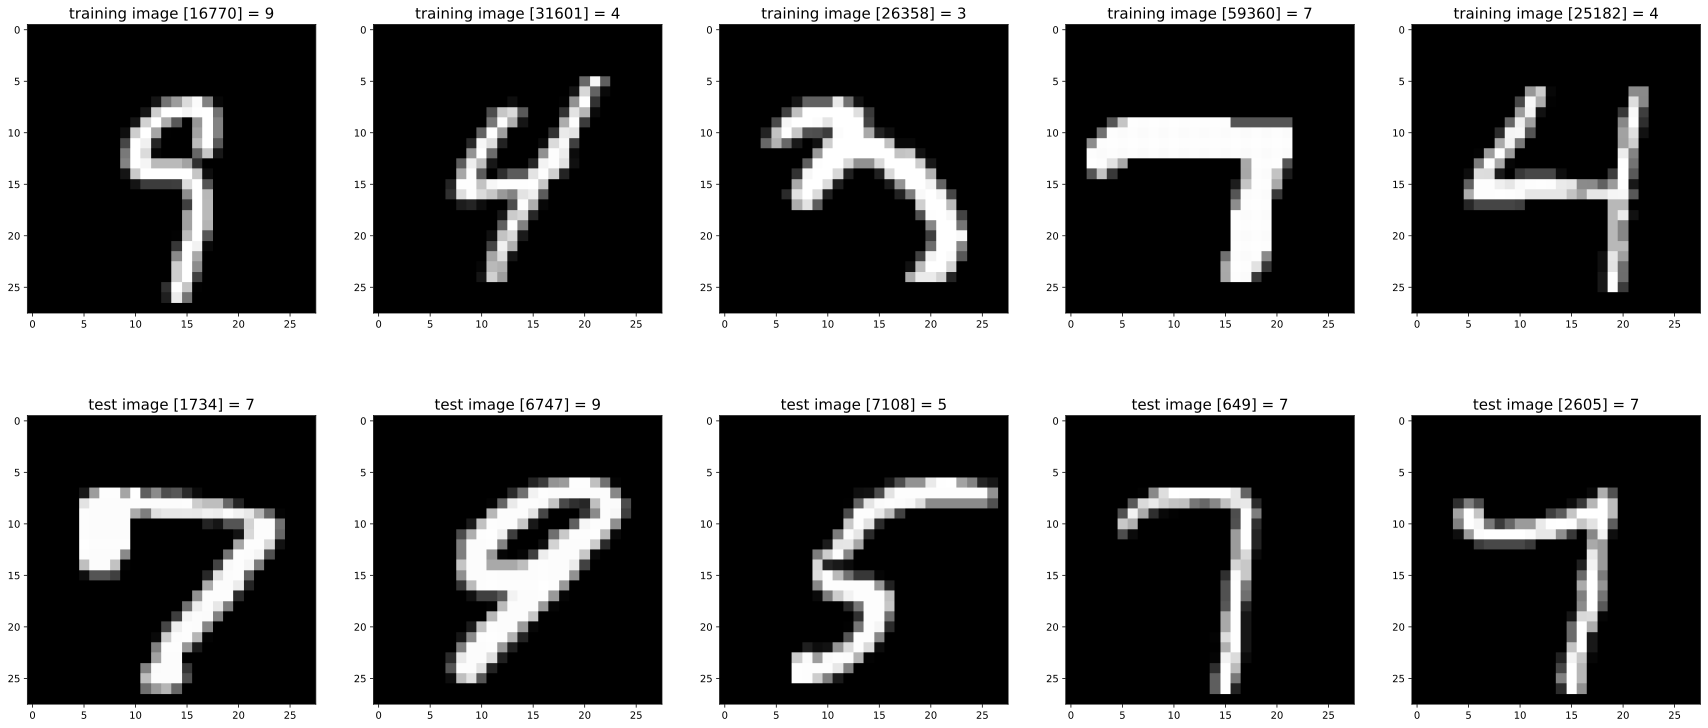

In [4]:
images_2_show = []
titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_2_show.append(X_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(X_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

## 1. Исследование скорости алгоритма.

In [5]:
strategies = ['my_own', 'brute', 'ball_tree', 'kd_tree']

np.random.seed(42)
features_10 = np.random.randint(0, 784, 10)
features_20 = np.random.randint(0, 784, 20)
features_100 = np.random.randint(0, 784, 100)

speed_results = pd.DataFrame(
    columns=['n_features', 'strategy', 'time']
)

for features in [features_10, features_20, features_100]:
    for strategy in strategies:
        time_start = time.time()
        knn = KNNClassifier(5, strategy, 'euclidean', False)
        knn.fit(X_train[:, features], y_train)
        y_pred = knn.predict(X_test[:, features])
        time_end = time.time()
        speed_results.loc[len(speed_results)] = [len(features), strategy, time_end - time_start]
        print([len(features), strategy, time_end - time_start])


[10, 'my_own', 8.351821184158325]
[10, 'brute', 7.946186065673828]
[10, 'ball_tree', 8.422169208526611]
[10, 'kd_tree', 2.470975160598755]
[20, 'my_own', 13.888370513916016]
[20, 'brute', 7.648877382278442]
[20, 'ball_tree', 36.79892539978027]
[20, 'kd_tree', 7.320333242416382]
[100, 'my_own', 71.50339245796204]
[100, 'brute', 7.983572483062744]
[100, 'ball_tree', 114.9482934474945]
[100, 'kd_tree', 97.63875222206116]


## 2. Оценка по кросс-валидации.

In [6]:
# Модификация функции `knn_cross_val_score`, чтобы также считать и время работы:
def knn_cross_val_score_timed(X, y, k_list, score, cv=None, **kwargs):
    if cv is None:
        n = X.shape[0]
        n_folds = 5
        cv = kfold(n, n_folds)

    result = {k: [np.zeros(len(cv)), np.zeros(len(cv))] for k in k_list}
    for fold_idx, (train_indices, val_indices) in enumerate(cv):
        X_train, y_train = X[train_indices], y[train_indices]
        X_val, y_val = X[val_indices], y[val_indices]
        for k in k_list:
            time_start = time.time()
            knn = KNNClassifier(k=k, **kwargs)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_val)
            time_end = time.time()
            if score == 'accuracy':
                result[k][0][fold_idx] = (y_pred == y_val).sum() / len(y_pred)
                result[k][1][fold_idx] = time_end - time_start
    return result
k_list = [k for k in range(1, 10 + 1)]
cv = kfold(X_train.shape[0], 3)

In [7]:
cv_euclidean = knn_cross_val_score_timed(X_train, y_train, k_list, 'accuracy', cv, strategy='brute', metric='euclidean', weights=False)
cv_euclidean

{1: [array([0.96895, 0.96675, 0.9667 ]),
  array([19.87840128, 19.96050525, 21.37800574])],
 2: [array([0.9603 , 0.95995, 0.96125]),
  array([20.23366117, 20.25993299, 21.77882338])],
 3: [array([0.96955, 0.96825, 0.96715]),
  array([20.52819681, 20.10694265, 21.46028423])],
 4: [array([0.96705, 0.9667 , 0.9671 ]),
  array([20.32391191, 19.75796986, 21.85448313])],
 5: [array([0.9681, 0.9673, 0.9672]),
  array([20.31789851, 20.25379038, 21.94340277])],
 6: [array([0.96555, 0.96495, 0.9657 ]),
  array([21.03851771, 20.24421334, 21.64626408])],
 7: [array([0.9652, 0.965 , 0.9656]),
  array([23.17592692, 21.58663654, 21.66136098])],
 8: [array([0.96415, 0.9639 , 0.96525]),
  array([20.06263399, 22.41769099, 21.18461442])],
 9: [array([0.9637 , 0.9632 , 0.96455]),
  array([21.20384479, 21.87582207, 21.63797593])],
 10: [array([0.96245, 0.9622 , 0.9637 ]),
  array([20.19006586, 21.65814853, 21.5620656 ])]}

In [8]:
cv_cosine = knn_cross_val_score_timed(X_train, y_train, k_list, 'accuracy', cv, strategy='brute', metric='cosine', weights=False)
cv_cosine

{1: [array([0.9733 , 0.9708 , 0.97045]),
  array([23.2486589 , 22.89890528, 21.06023717])],
 2: [array([0.96895, 0.9664 , 0.96775]),
  array([23.35102129, 22.96947002, 21.63995242])],
 3: [array([0.97365, 0.97155, 0.9709 ]),
  array([23.02456832, 23.23058653, 21.15032411])],
 4: [array([0.9725 , 0.97095, 0.9722 ]),
  array([22.92802024, 23.1776042 , 22.35101748])],
 5: [array([0.97275, 0.97015, 0.9716 ]),
  array([22.94305491, 22.79035282, 21.79597545])],
 6: [array([0.97195, 0.9697 , 0.97215]),
  array([23.39133   , 23.40992332, 21.97544098])],
 7: [array([0.97125, 0.96815, 0.97075]),
  array([23.56655979, 22.02704453, 21.55339408])],
 8: [array([0.97125, 0.96835, 0.97155]),
  array([23.58338881, 21.74359465, 22.07247138])],
 9: [array([0.97005, 0.967  , 0.9707 ]),
  array([23.09932733, 21.5912993 , 21.98904371])],
 10: [array([0.96935, 0.96615, 0.9707 ]),
  array([22.91622066, 22.19733191, 21.57536006])]}

## Влияние весов в алгоритме.

In [9]:
cv_euclidean_weights = knn_cross_val_score_timed(X_train, y_train, k_list, 'accuracy', cv, strategy='brute', metric='euclidean', weights=True)
cv_euclidean_weights

{1: [array([0.96895, 0.96675, 0.9667 ]),
  array([20.72063255, 20.41261101, 20.89362288])],
 2: [array([0.96895, 0.96675, 0.9667 ]),
  array([22.12116694, 20.30665469, 20.29851151])],
 3: [array([0.97075, 0.9691 , 0.96825]),
  array([21.6440239 , 19.94234037, 20.51952624])],
 4: [array([0.9713, 0.9698, 0.9701]),
  array([20.7322979 , 20.18902659, 20.41527653])],
 5: [array([0.96925, 0.96825, 0.96875]),
  array([21.30207205, 20.74529386, 20.39533114])],
 6: [array([0.9704 , 0.96845, 0.96945]),
  array([22.80188823, 20.63576007, 20.20349026])],
 7: [array([0.96735, 0.96595, 0.967  ]),
  array([20.86356544, 21.4934597 , 20.40856314])],
 8: [array([0.9676 , 0.96665, 0.9678 ]),
  array([20.54708409, 20.75292778, 20.41738391])],
 9: [array([0.9651, 0.9643, 0.9657]),
  array([21.40860748, 20.69811273, 20.23071313])],
 10: [array([0.9647 , 0.96465, 0.9657 ]),
  array([21.58917761, 20.9680686 , 20.42173958])]}

In [10]:
cv_cosine_weights = knn_cross_val_score_timed(X_train, y_train, k_list, 'accuracy', cv, strategy='brute', metric='cosine', weights=True)
cv_cosine_weights

{1: [array([0.9733 , 0.9708 , 0.97045]),
  array([21.83820248, 21.3637085 , 21.87041402])],
 2: [array([0.9733 , 0.9708 , 0.97045]),
  array([22.02470422, 21.79398489, 22.13507271])],
 3: [array([0.97495, 0.9725 , 0.97175]),
  array([21.95553708, 22.1049931 , 22.08123136])],
 4: [array([0.97545, 0.9732 , 0.97365]),
  array([21.70715332, 21.70233393, 21.93725419])],
 5: [array([0.974  , 0.97095, 0.973  ]),
  array([21.88766026, 21.8198936 , 21.99137735])],
 6: [array([0.97465, 0.9714 , 0.97305]),
  array([21.79250193, 21.96307397, 21.5746243 ])],
 7: [array([0.9726 , 0.9693 , 0.97195]),
  array([21.80865884, 21.88801098, 21.66732383])],
 8: [array([0.97295, 0.97045, 0.9722 ]),
  array([21.78392386, 22.04761171, 21.84953237])],
 9: [array([0.97165, 0.96865, 0.97145]),
  array([21.59805679, 21.99546885, 23.04306126])],
 10: [array([0.97145, 0.96855, 0.9714 ]),
  array([23.13754845, 21.76851344, 21.87078929])]}

### Сравнение методов

In [7]:
cv_results = pd.DataFrame(
    columns=['k', 'metric', 'weights', 'accuracy', 'time']
)

for metric, weights, cv_res in zip(['euclidean', 'cosine', 'euclidean', 'cosine'], 
                                   [False, False, True, True],
                                   [cv_euclidean.items(), cv_cosine.items(), cv_euclidean_weights.items(), cv_cosine_weights.items()]):
    for k, (accuracy_array, time_array) in cv_res:
        for accuracy_val, time_val in zip(accuracy_array, time_array):
            cv_results.loc[len(cv_results)] = [k, metric, weights, accuracy_val, time_val]

cv_euclidean = cv_results[(cv_results['weights'] == False) & (cv_results['metric'] == 'euclidean')]
cv_cosine = cv_results[(cv_results['weights'] == False) & (cv_results['metric'] == 'cosine')]
cv_euclidean_weights = cv_results[(cv_results['weights'] == True) & (cv_results['metric'] == 'euclidean')]
cv_cosine_weights = cv_results[(cv_results['weights'] == True) & (cv_results['metric'] == 'cosine')]

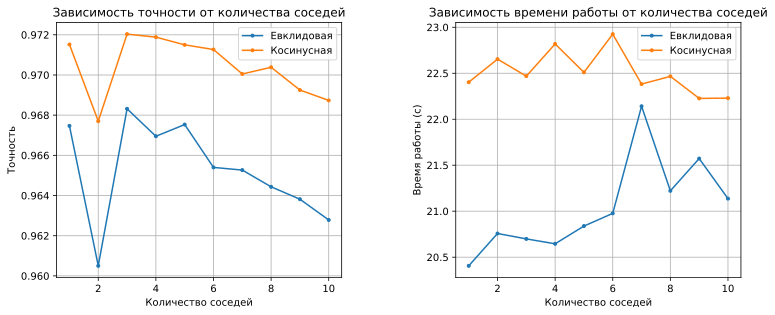

In [32]:
fig, ax = plt.subplot_mosaic([['accuracy', 'time']])

#plt.suptitle('Доля правильных ответов и точность на невзвешенном KNN')

ax['accuracy'].plot(cv_euclidean.groupby(by=['k'])['accuracy'].mean(), marker='.', label='Евклидовая')
ax['accuracy'].plot(cv_cosine.groupby(by=['k'])['accuracy'].mean(), marker='.', label='Косинусная')
ax['accuracy'].set_title('Зависимость точности от количества соседей')
ax['accuracy'].set_xlabel('Количество соседей')
ax['accuracy'].set_ylabel('Точность')
ax['accuracy'].legend()
ax['accuracy'].grid()

ax['time'].plot(cv_euclidean.groupby(by=['k'])['time'].mean(), marker='.', label='Евклидовая')
ax['time'].plot(cv_cosine.groupby(by=['k'])['time'].mean(), marker='.', label='Косинусная')
ax['time'].set_title('Зависимость времени работы от количества соседей')
ax['time'].set_xlabel('Количество соседей')
ax['time'].set_ylabel('Время работы (с)')
ax['time'].legend()
ax['time'].grid()

fig.set_size_inches(10.5, 4.5)
fig.tight_layout()

plt.subplots_adjust(wspace=0.4)
plt.savefig('1.svg')
plt.show()

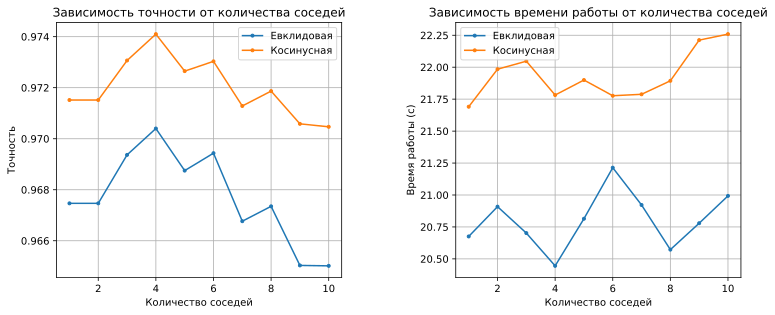

In [33]:
fig, ax = plt.subplot_mosaic([['accuracy', 'time']])

#plt.suptitle('Доля правильных ответов и точность на взвешенном KNN')

ax['accuracy'].plot(cv_euclidean_weights.groupby(by=['k'])['accuracy'].mean(), marker='.', label='Евклидовая')
ax['accuracy'].plot(cv_cosine_weights.groupby(by=['k'])['accuracy'].mean(), marker='.', label='Косинусная')
ax['accuracy'].set_title('Зависимость точности от количества соседей')
ax['accuracy'].set_xlabel('Количество соседей')
ax['accuracy'].set_ylabel('Точность')
ax['accuracy'].legend()
ax['accuracy'].grid()

ax['time'].plot(cv_euclidean_weights.groupby(by=['k'])['time'].mean(), marker='.', label='Евклидовая')
ax['time'].plot(cv_cosine_weights.groupby(by=['k'])['time'].mean(), marker='.', label='Косинусная')
ax['time'].set_title('Зависимость времени работы от количества соседей')
ax['time'].set_xlabel('Количество соседей')
ax['time'].set_ylabel('Время работы (с)')
ax['time'].legend()
ax['time'].grid()

fig.set_size_inches(10.5, 4.5)
fig.tight_layout()
plt.subplots_adjust(wspace=0.4)
plt.savefig('2.svg')
plt.show()

## 4. Применение лучшего алгоритма.

In [117]:
cv_results.loc[cv_results['accuracy'].argmax()]

k                   4
metric         cosine
weights          True
accuracy      0.97545
time        21.707153
Name: 99, dtype: object

In [118]:
knn = KNNClassifier(4, 'brute', 'cosine', True)
knn.fit(X_train, y_train)
distances, indices = knn.find_kneighbors(X_test, True)
y_pred = knn.predict(X_test)

In [163]:
import sklearn
from sklearn.metrics import confusion_matrix

x = confusion_matrix(y_test, y_pred)
x

array([[ 977,    1,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1129,    3,    1,    0,    0,    2,    0,    0,    0],
       [   8,    0, 1009,    1,    1,    0,    0,    8,    5,    0],
       [   0,    1,    3,  976,    1,   12,    0,    4,    9,    4],
       [   2,    1,    0,    0,  946,    0,    6,    2,    0,   25],
       [   4,    0,    0,    9,    1,  863,    7,    1,    4,    3],
       [   3,    3,    0,    0,    1,    3,  948,    0,    0,    0],
       [   2,   10,    4,    0,    1,    0,    0,  998,    0,   13],
       [   7,    1,    2,    9,    3,    3,    5,    4,  936,    4],
       [   7,    7,    2,    5,    7,    3,    1,    4,    3,  970]])

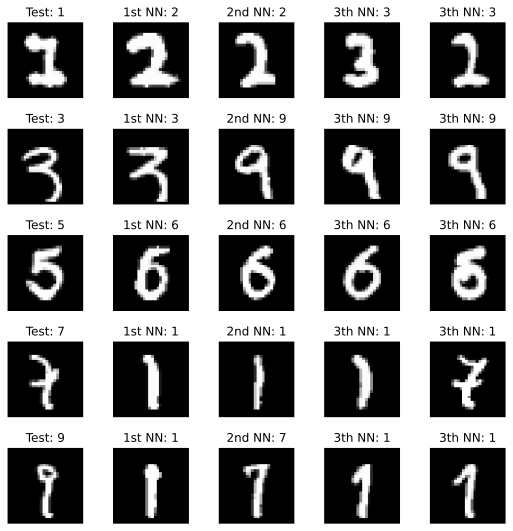

In [298]:
r = list(range(1, 10, 2))

fig, ax = plt.subplots(len(r), 5)
fig.set_size_inches(5 * 1.5, len(r) * 1.5)
for ind, i in enumerate(r):
    image = X_test[(y_test == i) & (y_pred != i)][1].reshape(28, 28)
    ax[ind, 0].imshow(image, cmap=plt.cm.gray)
    ax[ind, 0].axis("off")
    ax[ind, 0].set_title(f"Test: {i}"); 
    for j in range(1, 5):
        ax[ind, j].axis("off")
        image_test = X_train[indices[(y_test == i) & (y_pred != i)][1]][j - 1].reshape(28, 28)
        if j == 1:
            label = f"{j}st NN: {y_train[indices[(y_test == i) & (y_pred != i)][1]][j - 1]}"
        if j == 2:
            label = f"{j}nd NN: {y_train[indices[(y_test == i) & (y_pred != i)][1]][j - 1]}"
        if j == 3:
            label = f"{j}rd NN: {y_train[indices[(y_test == i) & (y_pred != i)][1]][j - 1]}"
        if j == 3:
            label = f"{j}th NN: {y_train[indices[(y_test == i) & (y_pred != i)][1]][j - 1]}"
        ax[ind, j].set_title(label)
        ax[ind, j].imshow(image_test, cmap=plt.cm.gray)

fig.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.savefig(f's{len(r)}.svg')
plt.show()


## 5. Аугментация обучающей выборки

In [380]:
import cv2
from skimage import filters, morphology
from sklearn.model_selection import KFold
import itertools

In [396]:
rotations = [-15, -10, -5, 5, 10, 15]
biases = [ (i, j) for i in range(1, 4) for j in range(1, 4)]
sigmas = [0.5, 1, 1.5]
morph_operations = list(itertools.chain.from_iterable(itertools.combinations(['erode', 'dilate', 'open', 'close'], r) for r in range(1, 4 + 1)))

In [656]:
def rotate_image(image, angle):
    matrix = cv2.getRotationMatrix2D((image.shape[1] // 2, image.shape[0] // 2), angle, 1)
    image = cv2.warpAffine(image, matrix, image.shape)
    return image

def bias_image(image, bias):
    matrix = np.float32([[1, 0, bias[0]], [0, 1, bias[1]]])
    image = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
    return image

def morphological_transform(image, operations):
    kernel = np.ones((2, 2), np.uint8)
    for op in operations:
        if op == 'erode':
            image = cv2.erode(image, kernel, iterations=1)
        elif op == 'dilate':
            image = cv2.dilate(image, kernel, iterations=1)
        elif op == 'open':
            image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        elif op == 'close':
            image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return image
            
def gaussian_filter(image, sigma):
    return cv2.GaussianBlur(image, (0, 0), sigma)

def augment_image(image, params):
    if 'angle' in params:
        image = rotate_image(image, params['angle'])
    if 'bias' in params:
        image = bias_image(image, params['bias'])
    if 'operation' in params:
        image = morphological_transform(image, params['operation'])
    if 'sigma' in params:
        image = gaussian_filter(image, params['sigma'])
    return image

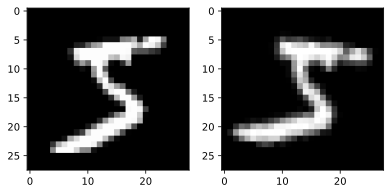

In [423]:
params = {
    'angle': rotations[0], 
}
x = X_train[0].reshape(28, 28)
y = augment_image(x, params)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(x, cmap=plt.cm.gray)
ax[1].imshow(y, cmap=plt.cm.gray)

In [506]:
def knn_cross_val_score_augmentation(X, y, params_list, score, cv=None, **kwargs):
    if cv is None:
        n = X.shape[0]
        n_folds = 5
        cv = kfold(n, n_folds)

    result = {tuple(params.items()): [np.zeros(len(cv)), 0] for params in params_list}
    for params in params_list:
        X_aug = np.zeros_like(X)
        for i in range(X.shape[0]):
            X_aug[i] = augment_image(X[i].reshape(28, 28), params).reshape(1, 784)
        p = tuple(params.items())
        for fold_idx, (train_indices, val_indices) in enumerate(cv):
            X_train_aug = X_aug[train_indices]
            X_val_aug = X_aug[val_indices]
            
            X_train, y_train = X[train_indices], y[train_indices]
            X_val, y_val = X[val_indices], y[val_indices]
            
            knn = KNNClassifier(**kwargs)
            knn.fit(np.vstack((X_train, X_train_aug)), np.hstack((y_train, y_train)))
            y_pred = knn.predict(np.vstack((X_val, X_val_aug)))
            if score == 'accuracy':
                result[p][0][fold_idx] = (y_pred == np.hstack((y_val, y_val))).sum() / len(y_pred)
        result[p][1] = result[p][0].mean()
        print(p, result[p][1])
    return result

In [672]:
X_train_new = np.zeros_like(X_train)
X_test_new = np.zeros_like(X_test)

for i in range(X_train.shape[0]):
    X_train_new[i] = augment_image(X_train[i].reshape(28, 28), params_opt).reshape(1, 784)

for i in range(X_test.shape[0]):
    X_test_new[i] = augment_image(X_test[i].reshape(28, 28), params_opt).reshape(1, 784)

X_train_new = np.vstack((X_train, X_train_new))
X_test_new = np.vstack((X_test, X_test_new))
y_train_new = np.hstack((y_train, y_train))
y_test_new = np.hstack((y_test, y_test))

In [673]:
knn = KNNClassifier(4, 'brute', 'cosine', True)
knn.fit(X_train_new, y_train_new)
y_pred = knn.predict(X_test)
print('accuracy:', (y_pred == y_test).sum() / len(y_pred))
conf = confusion_matrix(y_test, y_pred)
conf

accuracy: 0.9751


array([[ 978,    0,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1129,    3,    1,    0,    0,    2,    0,    0,    0],
       [   7,    0, 1011,    1,    1,    0,    0,    8,    4,    0],
       [   0,    1,    3,  976,    0,   12,    0,    5,    9,    4],
       [   2,    1,    0,    0,  945,    0,    6,    2,    0,   26],
       [   4,    0,    0,    9,    2,  862,    7,    1,    4,    3],
       [   3,    3,    0,    0,    1,    3,  948,    0,    0,    0],
       [   2,   11,    4,    0,    1,    0,    0,  997,    0,   13],
       [   7,    1,    2,    9,    3,    3,    5,    4,  936,    4],
       [   7,    7,    2,    5,    7,    3,    1,    5,    3,  969]])

In [674]:
knn.fit(X_train_new, y_train_new)
y_pred_new = knn.predict(X_test_new)
print('accuracy:', (y_pred_new == y_test_new).sum() / len(y_pred_new))
conf2 = confusion_matrix(y_test_new, y_pred_new)
conf2

accuracy: 0.97435


array([[1955,    0,    0,    0,    0,    0,    3,    2,    0,    0],
       [   0, 2256,    5,    1,    0,    0,    6,    0,    2,    0],
       [  14,    0, 2019,    2,    2,    0,    0,   17,   10,    0],
       [   0,    1,    6, 1949,    1,   20,    0,   12,   22,    9],
       [   3,    2,    0,    0, 1879,    0,   11,    3,    0,   66],
       [   7,    0,    0,   28,    4, 1713,   15,    2,   10,    5],
       [   5,    6,    0,    0,    1,    5, 1898,    0,    1,    0],
       [   4,   16,   12,    2,    2,    0,    0, 1991,    1,   28],
       [  16,    3,    3,   12,    5,    6,    7,    6, 1883,    7],
       [  12,   14,    2,   12,   10,    5,    2,   10,    7, 1944]])

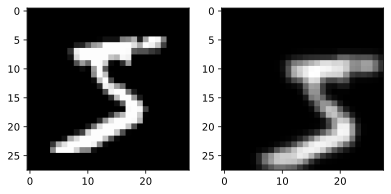

In [675]:
params = params_list_morph_operations[9]
x = X_train[0].reshape(28, 28)
y1 = augment_image(x, params)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(x, cmap=plt.cm.gray)
ax[1].imshow(y1, cmap=plt.cm.gray)

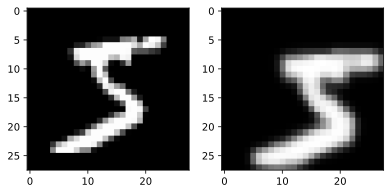

In [676]:
params = params_list_morph_operations[8]
x = X_train[0].reshape(28, 28)
y2 = augment_image(x, params)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(x, cmap=plt.cm.gray)
ax[1].imshow(y2, cmap=plt.cm.gray)

In [745]:
params_opt_corr = {'angle': -5, 'bias': (1, 1), 'sigma': 0.5, 'operation': ('dilate')}

In [746]:
X_train_aug = np.zeros_like(X_train)
X_test_aug = np.zeros_like(X_test)

for i in range(X_train.shape[0]):
    X_train_aug[i] = augment_image(X_train[i].reshape(28, 28), params_opt_corr).reshape(1, 784)

for i in range(X_test.shape[0]):
    X_test_aug[i] = augment_image(X_test[i].reshape(28, 28), params_opt_corr).reshape(1, 784)


In [680]:
knn = KNNClassifier(4, 'brute', 'cosine', True)
knn.fit(X_train_new, y_train_new)
y_pred = knn.predict(X_test)
print('accuracy:', (y_pred == y_test).sum() / len(y_pred))
conf = confusion_matrix(y_test, y_pred)
conf

accuracy: 0.9751


array([[ 978,    0,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1129,    3,    1,    0,    0,    2,    0,    0,    0],
       [   7,    0, 1011,    1,    1,    0,    0,    8,    4,    0],
       [   0,    1,    3,  976,    0,   12,    0,    5,    9,    4],
       [   2,    1,    0,    0,  945,    0,    6,    2,    0,   26],
       [   4,    0,    0,    9,    2,  862,    7,    1,    4,    3],
       [   3,    3,    0,    0,    1,    3,  948,    0,    0,    0],
       [   2,   11,    4,    0,    1,    0,    0,  997,    0,   13],
       [   7,    1,    2,    9,    3,    3,    5,    4,  936,    4],
       [   7,    7,    2,    5,    7,    3,    1,    5,    3,  969]])

In [681]:
knn = KNNClassifier(4, 'brute', 'cosine', True)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('accuracy:', (y_pred == y_test).sum() / len(y_pred))
conf1 = confusion_matrix(y_test, y_pred)
conf1

accuracy: 0.9752


array([[ 977,    1,    0,    0,    0,    0,    1,    1,    0,    0],
       [   0, 1129,    3,    1,    0,    0,    2,    0,    0,    0],
       [   8,    0, 1009,    1,    1,    0,    0,    8,    5,    0],
       [   0,    1,    3,  976,    1,   12,    0,    4,    9,    4],
       [   2,    1,    0,    0,  946,    0,    6,    2,    0,   25],
       [   4,    0,    0,    9,    1,  863,    7,    1,    4,    3],
       [   3,    3,    0,    0,    1,    3,  948,    0,    0,    0],
       [   2,   10,    4,    0,    1,    0,    0,  998,    0,   13],
       [   7,    1,    2,    9,    3,    3,    5,    4,  936,    4],
       [   7,    7,    2,    5,    7,    3,    1,    4,    3,  970]])

In [692]:
conf1 - conf

array([[-1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0, -2,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  1,  0,  0, -1,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0, -1],
       [ 0,  0,  0,  0, -1,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, -1,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  1]])

In [735]:
params1 = {'angle': -5}
params2 = {'bias': (1, 1)}
params3 = {'sigma': 0.5}
params4 = {'operation': ('dilate')}

In [736]:
X_test1 = np.zeros_like(X_test)
X_test2 = np.zeros_like(X_test)
X_test3 = np.zeros_like(X_test)
X_test4 = np.zeros_like(X_test)

for i in range(y_test.shape[0]):
    X_test1[i] = augment_image(X_test[i].reshape(28, 28), params1).reshape(1, 784)
    X_test2[i] = augment_image(X_test[i].reshape(28, 28), params2).reshape(1, 784)
    X_test3[i] = augment_image(X_test[i].reshape(28, 28), params3).reshape(1, 784)
    X_test4[i] = augment_image(X_test[i].reshape(28, 28), params4).reshape(1, 784)


In [737]:
knn = KNNClassifier(4, 'brute', 'cosine', True)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred1 = knn.predict(X_test1)
y_pred2 = knn.predict(X_test2)
y_pred3 = knn.predict(X_test3)
y_pred4 = knn.predict(X_test4)

In [742]:
Y_pred = np.vstack((y_pred, y_pred1, y_pred2, y_pred3)).T
Y_pred

print('accuracy:', (y_pred == y_test).sum() / len(y_test))
print('accuracy:', (y_pred1 == y_test).sum() / len(y_test))
print('accuracy:', (y_pred2 == y_test).sum() / len(y_test))
print('accuracy:', (y_pred3 == y_test).sum() / len(y_test))
print('accuracy:', (y_pred4 == y_test).sum() / len(y_test))

accuracy: 0.9752
accuracy: 0.9726
accuracy: 0.8797
accuracy: 0.9738
accuracy: 0.9752


In [739]:
y_pred_final = np.zeros_like(y_test)
for i, classes in enumerate(Y_pred):
    d = np.zeros(10, dtype=int)
    for cl in classes:
        d[cl] += 1
    y_pred_final[i] = d.argmax()
print('accuracy:', (y_pred_final == y_test).sum() / len(y_test))
conf6 = confusion_matrix(y_test, y_pred_final)
conf6

accuracy: 0.9741


array([[ 978,    1,    0,    0,    0,    0,    0,    1,    0,    0],
       [   0, 1132,    2,    1,    0,    0,    0,    0,    0,    0],
       [  14,    0, 1003,    0,    1,    0,    0,    9,    5,    0],
       [   0,    1,    2,  985,    1,    5,    0,    4,    8,    4],
       [   2,    2,    0,    0,  946,    0,    6,    2,    0,   24],
       [   5,    0,    0,   15,    1,  854,    5,    1,    7,    4],
       [   4,    3,    0,    0,    1,    2,  948,    0,    0,    0],
       [   4,   10,    6,    0,    1,    1,    0,  997,    0,    9],
       [   7,    2,    2,   11,    3,    1,    5,    4,  935,    4],
       [   9,    8,    2,    4,    7,    4,    1,    7,    4,  963]])

In [779]:
Y_pred_1 = np.vstack((y_pred, y_pred1, y_pred3)).T
Y_pred_1

y_pred_final_1 = np.zeros_like(y_test)
for i, classes in enumerate(Y_pred_1):
    d = np.zeros(10, dtype=int)
    for cl in classes:
        d[cl] += 1
    y_pred_final_1[i] = d.argmax()
print('accuracy:', (y_pred_final_1 == y_test).sum() / len(y_test))
conf7 = confusion_matrix(y_test, y_pred_final_1)
conf7

accuracy: 0.9754


array([[ 977,    0,    0,    0,    0,    0,    2,    1,    0,    0],
       [   1, 1127,    3,    0,    0,    0,    4,    0,    0,    0],
       [   4,    1, 1016,    1,    1,    0,    1,    5,    3,    0],
       [   1,    1,    2,  991,    0,    8,    0,    4,    2,    1],
       [   0,    3,    0,    0,  951,    0,    5,    2,    0,   21],
       [   4,    0,    0,   10,    2,  856,    9,    1,    6,    4],
       [   5,    2,    0,    0,    1,    2,  948,    0,    0,    0],
       [   0,   17,    7,    0,    2,    0,    0,  991,    0,   11],
       [   6,    2,    4,   16,    3,    4,    6,    2,  928,    3],
       [   3,    8,    3,    6,    8,    0,    0,    8,    4,  969]])

In [749]:
np.vstack((X_train, X_train_aug)).shape

(120000, 784)

In [750]:
knn = KNNClassifier(4, 'brute', 'cosine', True)
knn.fit(np.vstack((X_train, X_train_aug)), np.hstack((y_train, y_train)))
y_pred = knn.predict(X_test)
y_pred1 = knn.predict(X_test1)
y_pred2 = knn.predict(X_test2)
y_pred3 = knn.predict(X_test3)
y_pred4 = knn.predict(X_test4)

In [776]:
Y_pred = np.vstack((y_pred, y_pred1, y_pred2, y_pred3)).T
Y_pred

print('accuracy0:', (y_pred == y_test).sum() / len(y_test))
print('accuracy1:', (y_pred1 == y_test).sum() / len(y_test))
print('accuracy2:', (y_pred2 == y_test).sum() / len(y_test))
print('accuracy3:', (y_pred3 == y_test).sum() / len(y_test))
print('accuracy4:', (y_pred4 == y_test).sum() / len(y_test))

y_pred_final = np.zeros_like(y_test)
for i, classes in enumerate(Y_pred):
    d = np.zeros(10, dtype=int)
    for cl in classes:
        d[cl] += 1
    y_pred_final[i] = d.argmax()
print('accuracy5:', (y_pred_final == y_test).sum() / len(y_test))
conf8 = confusion_matrix(y_test, y_pred_final)
conf8

accuracy0: 0.9755
accuracy1: 0.9732
accuracy2: 0.9765
accuracy3: 0.9747
accuracy4: 0.9755
accuracy5: 0.9768


array([[ 978,    0,    0,    0,    0,    0,    1,    1,    0,    0],
       [   1, 1128,    3,    0,    0,    0,    3,    0,    0,    0],
       [   4,    1, 1017,    1,    1,    0,    1,    5,    2,    0],
       [   0,    1,    2,  994,    0,    7,    0,    4,    1,    1],
       [   0,    3,    0,    0,  952,    0,    5,    2,    0,   20],
       [   4,    0,    0,   11,    2,  865,    6,    1,    1,    2],
       [   5,    2,    0,    0,    1,    2,  948,    0,    0,    0],
       [   0,   16,    7,    0,    3,    0,    0,  992,    0,   10],
       [   6,    2,    3,   16,    3,    4,    6,    3,  928,    3],
       [   3,    8,    3,    8,    8,    1,    0,    8,    4,  966]])

In [757]:
X_test_aug = np.zeros_like(X_test)
for i in range(y_test.shape[0]):
    X_test_aug[i] = augment_image(X_test[i].reshape(28, 28), params_opt_corr).reshape(1, 784)

In [758]:
y_pred_aug = knn.predict(X_test_aug)

In [816]:
Y_pred = np.vstack((y_pred, y_pred1, y_pred2, y_pred3, y_pred_aug, y_pred_aug)).T
Y_pred

print('accuracy0:', (y_pred == y_test).sum() / len(y_test))
print('accuracy1:', (y_pred1 == y_test).sum() / len(y_test))
print('accuracy2:', (y_pred2 == y_test).sum() / len(y_test))
print('accuracy3:', (y_pred3 == y_test).sum() / len(y_test))
print('accuracy4:', (y_pred4 == y_test).sum() / len(y_test))
print('accuracy5:', (y_pred_aug == y_test).sum() / len(y_test))

y_pred_final = np.zeros_like(y_test)
for i, classes in enumerate(Y_pred):
    d = np.zeros(10, dtype=int)
    for cl in classes:
        d[cl] += 1
    y_pred_final[i] = d.argmax()
print('accuracy7:', (y_pred_final == y_test).sum() / len(y_test))
conf9 = confusion_matrix(y_test, y_pred_final)
conf9

accuracy0: 0.9755
accuracy1: 0.9732
accuracy2: 0.9765
accuracy3: 0.9747
accuracy4: 0.9755
accuracy5: 0.9783
accuracy7: 0.9783


array([[ 979,    0,    0,    0,    0,    0,    0,    1,    0,    0],
       [   0, 1132,    3,    0,    0,    0,    0,    0,    0,    0],
       [   7,    2, 1015,    0,    0,    0,    0,    6,    2,    0],
       [   0,    0,    2,  993,    1,    6,    0,    4,    2,    2],
       [   1,    1,    0,    0,  956,    0,    4,    1,    0,   19],
       [   3,    0,    0,   13,    2,  861,    7,    1,    1,    4],
       [   4,    3,    0,    0,    1,    2,  948,    0,    0,    0],
       [   1,   14,    6,    1,    1,    0,    0,  998,    0,    7],
       [   5,    1,    3,   16,    3,    3,    5,    4,  931,    3],
       [   5,    7,    2,    7,    7,    1,    0,    6,    4,  970]])

In [790]:
conf9 - conf7

array([[ 2,  0,  0,  0,  0,  0, -2,  0,  0,  0],
       [-1,  5,  0,  0,  0,  0, -4,  0,  0,  0],
       [ 3,  1, -1, -1, -1,  0, -1,  1, -1,  0],
       [-1, -1,  0,  2,  1, -2,  0,  0,  0,  1],
       [ 1, -2,  0,  0,  5,  0, -1, -1,  0, -2],
       [-1,  0,  0,  3,  0,  5, -2,  0, -5,  0],
       [-1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, -3, -1,  1, -1,  0,  0,  7,  0, -4],
       [-1, -1, -1,  0,  0, -1, -1,  2,  3,  0],
       [ 2, -1, -1,  1, -1,  1,  0, -2,  0,  1]])

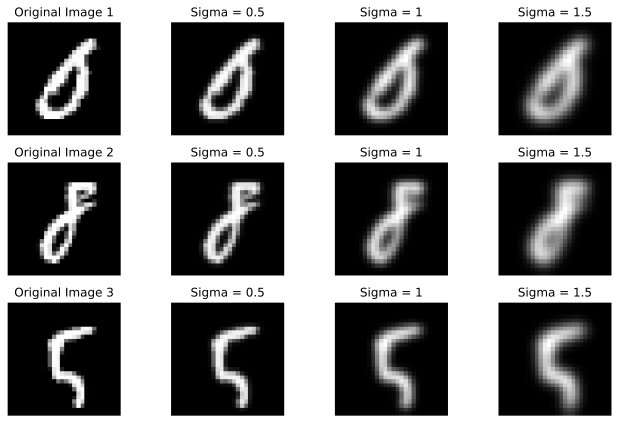

In [815]:

def apply_gaussian_filter(images, sigma_values):
    n_images = len(images)
    n_sigmas = len(sigma_values)
    
    fig, axes = plt.subplots(n_images, n_sigmas + 1, figsize=(9.5, n_images * 2))
    
    for i, image in enumerate(images):
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Original Image {i+1}')
        
        for j, sigma in enumerate(sigma_values):
            filtered_image = gaussian_filter(image, sigma=sigma)
            axes[i, j+1].imshow(filtered_image, cmap='gray')
            axes[i, j+1].axis('off')
            axes[i, j+1].set_title(f'Sigma = {sigma}')
    
    plt.tight_layout()
    plt.savefig('gauss.svg')
    plt.show()

image1 = X_train[3367].reshape(28, 28)
image2 = X_train[3425].reshape(28, 28)
image3 = X_train[100].reshape(28, 28)

images = [image1, image2, image3]
sigma_values = [0.5, 1, 1.5]

apply_gaussian_filter(images, sigma_values)